**Executive Summary**:

1. The SMS Spam Detection managed to achieve **98%** accuracy (**100%** precision and **84%** recall, **91%** F1 score).
2. The text has been cleaned up before passed to the RandomForest model. The text preprocessing involves converting to lower case, tokenize, remove stopwords, lemmatize, and eventually convert to TF-IDF. The other models have been tried like SupportVectorClassifier, XGBoost, LightGBM, Logistic Regression and KNearestNeighborClassifier (PR-AUC is used for model selection and hyperparameter finetuning).
3. Visualization the most common words in spam and ham classes and topic modelling using Latent Dirichlet Allocation (LDA).

In [1]:
import numpy as np 
import pandas as pd
import re
import os

import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
from gensim.models import LdaMulticore
import gensim.corpora as corpora
from pprint import pprint

# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Load data

In [2]:
df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv')

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
df.shape

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5572, 5)

In [4]:
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df = df.rename(columns={'v1':'tgt', 'v2':'text'})[['tgt','text']]

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# EDA

In [6]:
df.tgt.value_counts()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ham     4825
spam     747
Name: tgt, dtype: int64

Imbalanced class even though it is not that severe

In [7]:
df[df.tgt=='ham'].sample(10)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tgt,text
3954,ham,I knew it... U slept v late yest? Wake up so l...
5433,ham,You're gonna have to be way more specific than...
1625,ham,Hi Dear Call me its urgnt. I don't know whats ...
1458,ham,"Fighting with the world is easy, u either win ..."
2788,ham,�� got wat to buy tell us then �_ no need to c...
111,ham,Going for dinner.msg you after.
1384,ham,"Storming msg: Wen u lift d phne, u say \HELLO\..."
4677,ham,It is a good thing I'm now getting the connect...
2428,ham,She.s find. I sent you an offline message to k...
3286,ham,The gas station is like a block away from my h...


In [8]:
df[df.tgt=='spam'].sample(10)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tgt,text
2819,spam,INTERFLORA - ��It's not too late to order Inte...
3130,spam,LookAtMe!: Thanks for your purchase of a video...
659,spam,88800 and 89034 are premium phone services cal...
1717,spam,WOW! The Boys R Back. TAKE THAT 2007 UK Tour. ...
1128,spam,Ur HMV Quiz cash-balance is currently �500 - t...
1429,spam,For sale - arsenal dartboard. Good condition b...
647,spam,PRIVATE! Your 2003 Account Statement for shows...
762,spam,Urgent Ur �500 guaranteed award is still uncla...
575,spam,"You have won ?1,000 cash or a ?2,000 prize! To..."
4194,spam,Double mins and txts 4 6months FREE Bluetooth ...


# Preprocess data

Preprocess and clean up the data before we put the data into the model. The processes involves
1. Extract only alphabetical characters and convert them into lower case
2. Tokenize text
2. Remove stopwords (English) + short form of stopwords
3. Lemmatize the word
4. Convert the word into TF-IDF vectors
5. Process target to spam-->1, ham-->0

In [9]:
def clean_data(text):
    """
    Extract alphabetical characters and convert them into lower case.
    """
    out = re.sub('[^a-zA-Z]', ' ', text) 
    out = out.lower() 
    out = out.split()
    out = ' '.join(out)
    return out

def tokenize_word(text):
    """
    Convert sentence into list of tokens
    """
    return nltk.word_tokenize(text)

def remove_stopwords(text):
    """
    Remove English stopwords from text
    """
    stop_words = set(stopwords.words("english")+['u','ur','r','n']) 
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

def lemmatize_word(text):
    """
    Convert word into base form (lemmatize)
    """
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

def get_processed_tokens(text):
    """
    Do all above four preprocess steps.
    """
    text = clean_data(text)
    text = tokenize_word(text)
    text = remove_stopwords(text)
    text = lemmatize_word(text)
    return text

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
df['processed_text'] = df['text'].apply(get_processed_tokens)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# Create corpus of text for TF-IDF 
corpus= []
for i in df["processed_text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# Vectorize the corpus
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus).toarray()
X.shape

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5572, 6577)

In [13]:
# Process label
df['label'] = 0
df.loc[df.tgt=='spam', 'label']=1
df.label.value_counts()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    4825
1     747
Name: label, dtype: int64

In [14]:
y = df.label.values

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
y.shape

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5572,)

# Find common keywords/topics

This section is separate from SMS Spam Detection. This is to model the topics in the sms

In [16]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


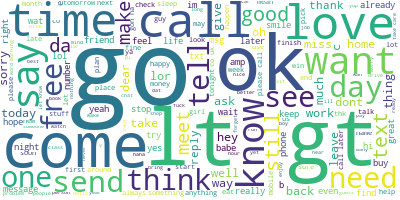

In [17]:
# All corpus
long_string = ' '.join(corpus)
wordcloud.generate(long_string)
wordcloud.to_image()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


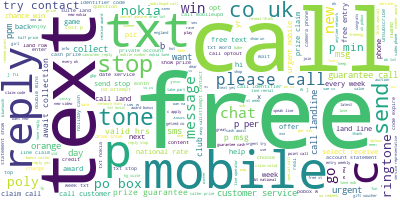

In [18]:
# Spam corpus
spam_corpus= []
for i in df[df.tgt=='spam']["processed_text"]:
    msg = ' '.join([row for row in i])
    spam_corpus.append(msg)
    
long_string = ' '.join(spam_corpus)
wordcloud.generate(long_string)
wordcloud.to_image()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


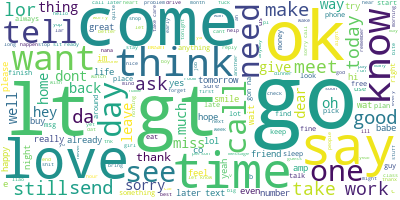

In [19]:
# Ham corpus
ham_corpus= []
for i in df[df.tgt=='ham']["processed_text"]:
    msg = ' '.join([row for row in i])
    ham_corpus.append(msg)

long_string = ' '.join(ham_corpus)
wordcloud.generate(long_string)
wordcloud.to_image()

In [20]:
id2word = corpora.Dictionary(df["processed_text"])
texts = df["processed_text"]
tdf = [id2word.doc2bow(text) for text in texts] #Term Document Frequency

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
num_topics = 8
lda_model = LdaMulticore(corpus=tdf,id2word=id2word,num_topics=num_topics, random_state=10)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[tdf]

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.020*"gt" + 0.020*"lt" + 0.017*"get" + 0.014*"call" + 0.013*"go" + '
  '0.008*"k" + 0.006*"send" + 0.006*"take" + 0.005*"pls" + 0.005*"please"'),
 (1,
  '0.016*"get" + 0.014*"call" + 0.010*"go" + 0.008*"think" + 0.007*"tell" + '
  '0.007*"free" + 0.007*"day" + 0.007*"make" + 0.006*"one" + 0.005*"say"'),
 (2,
  '0.011*"go" + 0.010*"get" + 0.009*"good" + 0.009*"gt" + 0.008*"lt" + '
  '0.008*"know" + 0.006*"day" + 0.006*"happy" + 0.006*"one" + 0.006*"ok"'),
 (3,
  '0.013*"call" + 0.013*"come" + 0.011*"get" + 0.010*"go" + 0.008*"think" + '
  '0.008*"want" + 0.007*"day" + 0.006*"home" + 0.006*"see" + 0.006*"like"'),
 (4,
  '0.014*"get" + 0.012*"go" + 0.010*"come" + 0.008*"call" + 0.008*"text" + '
  '0.008*"like" + 0.007*"send" + 0.007*"know" + 0.007*"make" + 0.006*"sorry"'),
 (5,
  '0.020*"get" + 0.010*"send" + 0.010*"go" + 0.010*"free" + 0.008*"stop" + '
  '0.008*"txt" + 0.008*"love" + 0.007*"tone" + 0.007*"lor" + 0.006*"week"'),
 (6,
  '0.030*"call" + 0.012*"time" + 0.009*"go" + 

In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, tdf, id2word)
LDAvis_prepared

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.047038  0.011448       1        1  15.078035
6     -0.070822 -0.069887       2        1  14.786462
4      0.050242 -0.011212       3        1  13.654190
3      0.007451  0.020854       4        1  12.313718
2      0.042907  0.033700       5        1  11.174781
0     -0.078114  0.080228       6        1  11.035928
1     -0.005899 -0.016007       7        1  11.018412
7      0.007197 -0.049123       8        1  10.938475, topic_info=      Term        Freq       Total Category  logprob  loglift
318     gt  279.000000  279.000000  Default  30.0000  30.0000
321     lt  277.000000  277.000000  Default  29.0000  29.0000
83    call  615.000000  615.000000  Default  28.0000  28.0000
47   think  184.000000  184.000000  Default  27.0000  27.0000
17      ok  257.000000  257.000000  Default  26.0000  26.0000
..     ...         ...         ...      ...      ...      ...
328    ask   18.116677  117.298008   Topic8  -5.6712   0.3450
414   good   19.640126  216.279512   Topic8  -5.5904  -0.1861
239   love   19.638952  219.090441   Topic8  -5.5905  -0.1991
58    send   19.970010  251.161790   Topic8  -5.5738  -0.3190
34    text   18.422654  174.541595   Topic8  -5.6544  -0.0357

[683 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
539       1  0.083460     abt
539       2  0.041730     abt
539       3  0.584219     abt
539       4  0.083460     abt
539       7  0.083460     abt
...     ...       ...     ...
491       4  0.177220      yo
491       5  0.088610      yo
491       7  0.383976      yo
491       8  0.088610      yo
4145      6  0.763292  zindgi

[1846 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 5, 4, 3, 1, 2, 8])

Based on the model above, most ham topics revolves around deciding when and where to go/meet, affirmation (ok), getting help, saying love/miss, etc.
Particularly for the spam class, it involves request some action from the recipient (call, text, reply), claim some prize / free stuff / cash. The topic 2 on above visualization is particularly far from other topics on the principal components 2-D plot and seems the topic is dominated by spam keywords.

# Model training

We will split 30% of dataset for evaluating the final model performance.
Since the dataset is quite small, we will test few models and find out the best algorithm that perform the best in cross validated dataset.

We will find the best model algorithm by using their default hyperparameter. The best model algorithm is further finetuned on its hyperparameter.
We will use PR-AUC / average_precision score as performance metrics to be optimized since it is imbalanced class.


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3900, 6577)
(1672, 6577)
(3900,)
(1672,)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
rfc = RandomForestClassifier(random_state=42)
svc = SVC(random_state=42)
xgb = XGBClassifier(random_state=42)
lgbm = LGBMClassifier(random_state=42)
lr = LogisticRegression(random_state=42)
knc = KNeighborsClassifier()

models=[rfc,svc,xgb,lgbm,lr,knc]

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
model_perf = pd.DataFrame()
metrics = ['f1','precision','recall','average_precision','roc_auc']
for model in models:
    scores = cross_validate(model,X_train,y_train,scoring=metrics,n_jobs=-1,cv=3)
    
    tmp = {}
    tmp['model'] = str(type(model).__name__)
    for test_metric in ['test_'+metric for metric in metrics]:
        tmp[test_metric] = np.mean(scores[test_metric])
    
    model_perf = model_perf.append(tmp,ignore_index=True)

model_perf.sort_values('test_average_precision', ascending=False)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,model,test_average_precision,test_f1,test_precision,test_recall,test_roc_auc
0,RandomForestClassifier,0.974955,0.888563,0.997636,0.801136,0.992242
1,SVC,0.973749,0.876541,0.993421,0.785985,0.991735
3,LGBMClassifier,0.956046,0.902204,0.922796,0.882576,0.983147
4,LogisticRegression,0.954451,0.771628,0.985712,0.636364,0.988871
2,XGBClassifier,0.946168,0.892877,0.918001,0.869318,0.981191
5,KNeighborsClassifier,0.667372,0.393936,0.993197,0.246212,0.815356


Based on the above tables, the most performing algorithm is **RandomForestClassifier**. The model is selected due to its **extremely high precision** (almost perfect precision) and **good recall**. In this case, I am keen toward to the model that has extremely high precision to ensure that we minimize the False Positive i.e. misclassify ham messages as spam. The alternative model that we can select if we try to maximize recall is **LGBMClassifier** and it has the highest F1 score. 

It has been shown that tree-based algorithm performed better in this case due to its sparse feature matrix.

In [27]:
params = {
    'n_estimators': [25,50,100,200,400,800],
    'min_samples_split':[2,3,4]
}

search = GridSearchCV(rfc, params, scoring='average_precision', n_jobs=-1, cv=5, refit=True)
# This process might take a while
search_result = search.fit(X_train, y_train)
print(search_result.best_params_)
print(search_result.best_score_)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'min_samples_split': 3, 'n_estimators': 800}
0.9799957627994346


In [28]:
best_model = search_result.best_estimator_

# best_model = RandomForestClassifier(random_state=42, min_samples_split=3, n_estimators=800)
# best_model.fit(X_train,Y_train)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Evaluate model on test set

In [29]:
y_test_pred = best_model.predict(X_test)

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
print('Accuracy score: %.2f' %(accuracy_score(y_test, y_test_pred)))
p,r,f,_ = precision_recall_fscore_support(y_test, y_test_pred, average='binary')
print("Precision= %.2f, Recall = %.2f, F1-score = %.2f" % (p,r,f))

Accuracy score: 0.98
Precision= 1.00, Recall = 0.84, F1-score = 0.91


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The model has perfect precision (100%) and 84% recall

------- End of notebook---------------------